In [ ]:
! pip install pykrx 

from pykrx import stock

import ipywidgets as widgets 
from ipywidgets import interact, interact_manual 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 

data = stock.get_market_ohlcv_by_date(fromdate="20150104", todate="20211202", ticker="066570")

In [ ]:
data

,시가,고가,저가,종가,거래량
날짜,,,,,
2015-01-05,58500,58900,57500,58400,379003
2015-01-06,58100,60500,57700,60100,799629
2015-01-07,59500,60600,59300,60000,703542
2015-01-08,60300,63000,60300,62200,1404924
2015-01-09,62600,63500,61600,61700,790827
...,...,...,...,...,...
2021-11-26,125500,126500,121500,122000,872482
2021-11-29,118000,122000,118000,119500,933062
2021-11-30,120500,122000,115000,115500,1809765


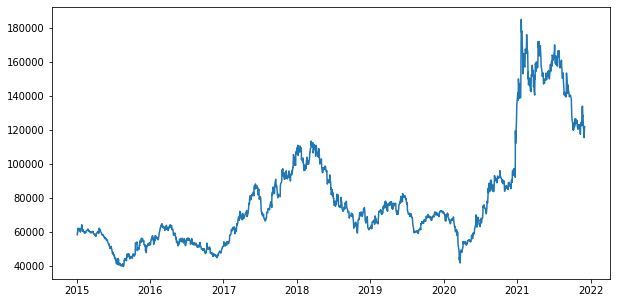

In [ ]:
#y 확인
plt.figure(figsize=(10,5))
plt.plot(data['종가'])
plt.show()

In [ ]:
def make_datasetshape(feature_np,label_np, window_size):
  feature_list=[]
  label_list=[]
  for i in range(len(feature_np)-window_size):
    feature_list.append(feature_np[i:i+window_size])
    label_list.append(label_np[i+window_size])
  return np.array(feature_list), np.array(label_list)

#window_size는 40으로 지정해둔다.
window_size=40
X, Y= make_datasetshape(feature_np, label_np, window_size)
print(X.shape, Y.shape)

(1662, 40, 5) (1662, 1)


In [ ]:
#train test 0.7 0.3 비율로 나눈다.
len_train=int(len(X)*0.7)
x_train=X[0:len_train]
y_train=Y[0:len_train]
x_test=X[len_train:]
y_test=Y[len_train:]

In [ ]:
#모델 구현
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Sequential
model=Sequential()
model.add(LSTM(128,return_sequences=True, input_shape=x_train[0].shape))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 40, 128)           68608     
                                                                 
 lstm_3 (LSTM)               (None, 40, 128)           131584    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 331,905
Trainable params: 331,905
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
model.compile(loss='mse', optimizer='adam',metrics=['mae'])
early_stop=EarlyStopping(monitor='val_loss', patience=5)
model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
37/37 [==============================] - 11s 139ms/step - loss: 0.0034 - mae: 0.0376
Epoch 2/100
37/37 [==============================] - 5s 142ms/step - loss: 7.0564e-04 - mae: 0.0207
Epoch 3/100
37/37 [==============================] - 5s 141ms/step - loss: 5.7723e-04 - mae: 0.0188
Epoch 4/100
37/37 [==============================] - 5s 141ms/step - loss: 5.1730e-04 - mae: 0.0175
Epoch 5/100
37/37 [==============================] - 5s 142ms/step - loss: 4.6639e-04 - mae: 0.0165
Epoch 6/100
37/37 [==============================] - 5s 139ms/step - loss: 3.8633e-04 - mae: 0.0153
Epoch 7/100
37/37 [==============================] - 5s 139ms/step - loss: 3.7272e-04 - mae: 0.0150
Epoch 8/100
37/37 [==============================] - 5s 141ms/step - loss: 3.5153e-04 - mae: 0.0143
Epoch 9/100
37/37 [==============================] - 5s 139ms/step - loss: 3.5885e-04 - mae: 0.0145
Epoch 10/100
37/37 [==============================] - 5s 141ms/step - loss: 3.4404e-04 - mae: 0.0142
Ep

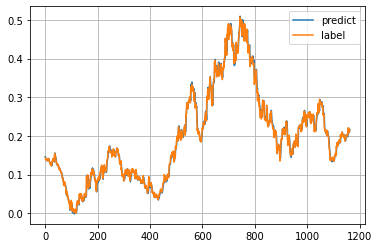

In [ ]:
#정확도 및 손실 
train_pred=model.predict(x_train)
test_pred=model.predict(x_test)
#학습결과 그림으로 확인
plt.plot(train_pred, label='predict')
plt.plot(y_train, label='label')
plt.grid()
plt.legend(loc='best')
plt.show()

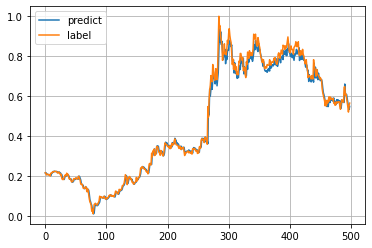

In [ ]:
#그림으로 확인
plt.plot(test_pred, label='predict')
plt.plot(y_test, label='label')
plt.grid()
plt.legend(loc='best')
plt.show()

In [ ]:
x_test.shape

(499, 40, 5)

In [ ]:
# invert scaling for forecast
train_pred=train_pred.reshape(-1,1)
test_pred=test_pred.reshape(-1,1)
train_pred_inver=scaler.inverse_transform(train_pred)
test_pred_inver=scaler.inverse_transform(test_pred)
# invert scaling for actual
y_train_inver=scaler.inverse_transform(y_train)
y_test_inver=scaler.inverse_transform(y_test)
#mape
from sklearn.metrics import mean_absolute_percentage_error
mape_test=mean_absolute_percentage_error(test_pred_inver,y_test_inver)
mape_train=mean_absolute_percentage_error(train_pred_inver,y_train_inver)
print(mape_train, mape_test)

0.01595356238505516 0.022199142331078277
